In [16]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm

nifty_tickers = [
    "COALINDIA.NS", 
    "POWERGRID.NS", 
    "ONGC.NS", 
    "TECHM.NS", 
    "NTPC.NS", 
    "HCLTECH.NS", 
    "ITC.NS", 
    "TCS.NS", 
    "HEROMOTOCO.NS", 
    "TATASTEEL.NS", 
    "BAJAJ-AUTO.NS", 
    "INFY.NS", 
    "SBIN.NS", 
    "UPL.NS", 
    "HINDUNILVR.NS", 
    "BRITANNIA.NS", 
    "LT.NS", 
    "HDFCBANK.NS", 
    "BPCL.NS", 
    "M&M.NS"
]

start_date = "2022-01-01"
end_date = "2023-01-01"

nifty_data = yf.download(nifty_tickers, start=start_date, end=end_date)['Adj Close']


returns = nifty_data.pct_change().dropna()

[*********************100%***********************]  20 of 20 completed


Selected tickers: ['HINDUNILVR.NS', 'BAJAJ-AUTO.NS', 'TECHM.NS', 'UPL.NS', 'ONGC.NS']
[(('TCS.NS', 'UPL.NS'), -0.19427974251571803), (('ONGC.NS', 'UPL.NS'), -0.1668803635113896), (('HCLTECH.NS', 'UPL.NS'), -0.048967981083772406), (('ITC.NS', 'UPL.NS'), -0.004849034336760688), (('TECHM.NS', 'TCS.NS'), -0.0016432469707020698)]
[(('HDFCBANK.NS', 'BPCL.NS'), 0.7040139724181074), (('NTPC.NS', 'HDFCBANK.NS'), 0.7128158750680448), (('NTPC.NS', 'HEROMOTOCO.NS'), 0.7453271480850117), (('HEROMOTOCO.NS', 'BPCL.NS'), 0.7515712194581532)]


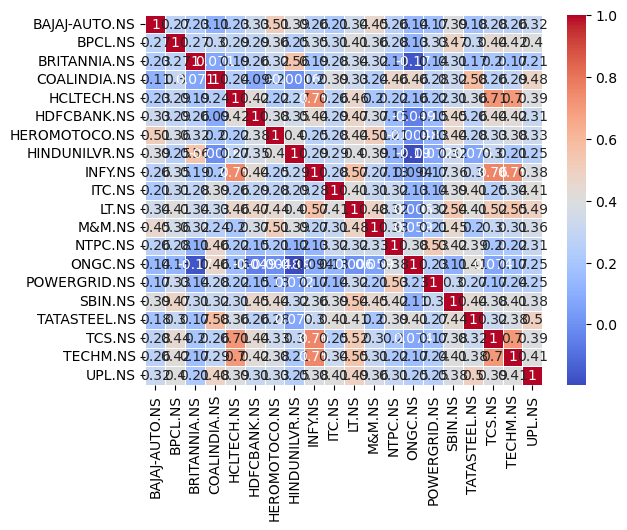

In [21]:
#Using correlation matrix

correlation_matrix = returns.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

uncorrelated_pairs = []

for i in range(len(nifty_tickers)):  # 20C20 Combinations
    for j in range(i+1, len(nifty_tickers)):
        uncorrelated_pairs.append(((nifty_tickers[i], nifty_tickers[j]), correlation_matrix.iloc[i, j]))

# Sort ascending order
uncorrelated_pairs.sort(key=lambda x: x[1])

selected_pairs = uncorrelated_pairs[:10]

selected_tickers = set() 
for pair, _ in selected_pairs:
    selected_tickers.update(pair)
    
selected_tickers_list = list(selected_tickers)

print("Selected tickers:", selected_tickers_list[:5])
#print(returns)
#print(correlation_matrix)
print(uncorrelated_pairs[:5]) # lowest 5
print(uncorrelated_pairs[-5:-1]) # highest 5



In [30]:
#Regression

regression_results = pd.DataFrame(index=nifty_tickers, columns=nifty_tickers)

for stock1 in nifty_tickers:
    for stock2 in nifty_tickers:
        if stock1 != stock2:
            X = sm.add_constant(returns[stock1])
            y = returns[stock2]
            model = sm.OLS(y, X).fit()
            regression_results.loc[stock1, stock2] = model.params[stock1]

regression_results = regression_results.apply(pd.to_numeric)

# sort by regression coefficients
sorted_coefficients = regression_results.unstack().sort_values()

# 5 stocks with the lowest coefficients
selected_tickers = set(sorted_coefficients.head(5).index.get_level_values(1))

print("Selected tickers:", selected_tickers)

Selected tickers: {'HINDUNILVR.NS', 'ONGC.NS', 'HDFCBANK.NS', 'BRITANNIA.NS'}


In [26]:
# using granger
granger_test_results = pd.DataFrame(index=nifty_tickers, columns=nifty_tickers)

for stock1 in nifty_tickers:
    for stock2 in nifty_tickers:
        if stock1 != stock2:
            data = pd.DataFrame({'X': returns[stock1], 'Y': returns[stock2]})
            
            max_lag = 5  
            test_result = grangercausalitytests(data, max_lag, verbose=False)
            
            p_value = test_result[max_lag][0]['ssr_ftest'][1]
            granger_test_results.loc[stock1, stock2] = p_value

granger_test_results = granger_test_results.apply(pd.to_numeric)

sorted_p_values = granger_test_results.unstack().sort_values()

# 5 stocks with the lowest p-values
selected_tickers = set(sorted_p_values.head(5).index.get_level_values(1))

print("Selected tickers:", selected_tickers)

Selected tickers: {'UPL.NS', 'ONGC.NS', 'NTPC.NS', 'HCLTECH.NS', 'SBIN.NS'}
